Overall plan / workflow (high level)

Data check & split — read train.csv/test.csv, confirm labels, display class counts (watch class imbalance).

Baseline model — small CNN from scratch to set a floor.
Primary experiments — EfficientNetV2 (feature-extract → unfreeze top N layers) + augmentation.

Challenger experiments — MobileNetV3 and ViT-small (with augmentation + regularizers).

Validation — Stratified K-fold CV (k=5) or repeated stratified holdout; track per-class F1 & confusion matrix.

Training tricks — MixUp/CutMix, label smoothing, early stopping + model checkpoint, LR schedule (Cosine or ReduceLROnPlateau), weight decay; one-cycle if using PyTorch.

Postprocessing — TTA and soft ensemble of top models.

Interpretation — Grad-CAM per-class failure analysis.

Submit & iterate — pick the best candidate, tune further, ensemble.

  ikutin aja deh template gini cara kerjain cnn from sketch gimana

✅ Train CSV loaded successfully
✅ Test CSV loaded successfully
=== DATA OVERVIEW ===
Training samples: 1101
Test samples: 741

=== DATAFRAME STRUCTURE ===
Train columns: ['id', 'filename', 'label']
Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1101 non-null   int64 
 1   filename  1101 non-null   object
 2   label     1101 non-null   object
dtypes: int64(1), object(2)
memory usage: 25.9+ KB
None

Train head:
   id                              filename label
0   0  f4da1e77cfbd47e9bf8030e471e0cd58.jpg  Naga
1   1  2390f5dcc0054cbe9100c2a794ea56e2.jpg  Naga
2   2  05b348ac8db74e5ba184a0f51afffee2.jpg  Naga
3   3  5460d1892fab4afdb555d223582105b0.jpg  Naga
4   4  0310279f903845648cf14214f7fbcaf4.jpg  Naga

Test columns: ['id', 'filename']
Test head:
   id                              filename
0   0  929c49c077f242cdb5f69f3638f2b

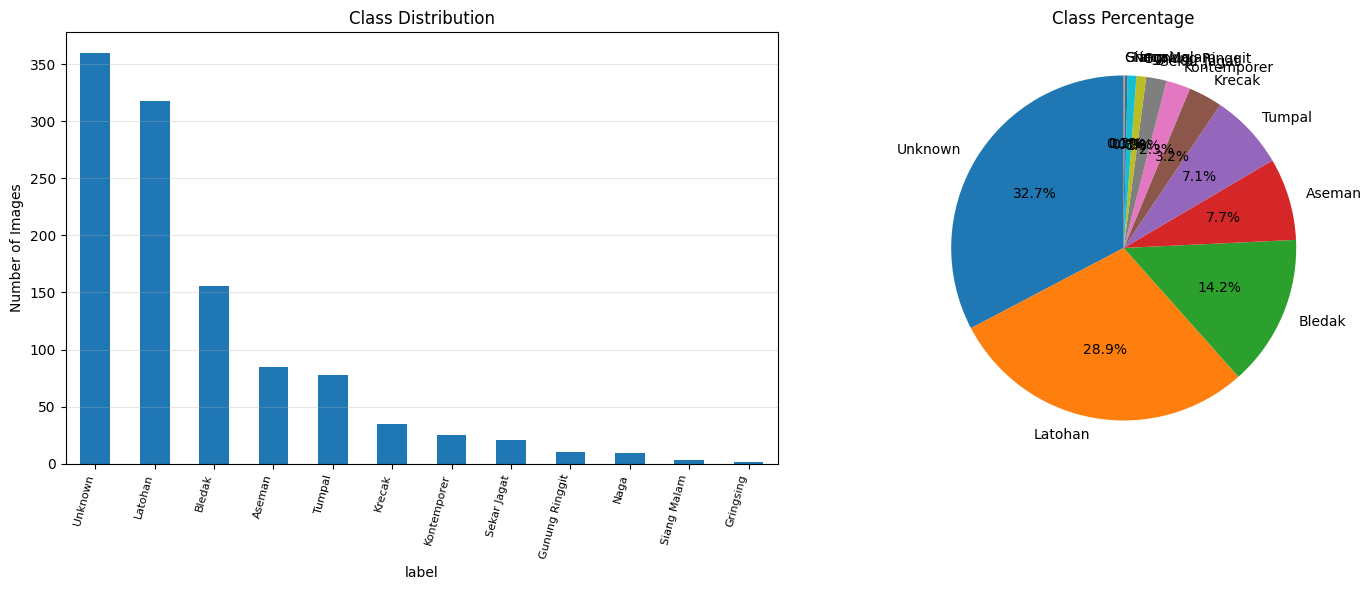


=== CLASS WEIGHTS ===
Aseman: 1.08
Bledak: 0.59
Gringsing: 91.75
Gunung Ringgit: 9.18
Kontemporer: 3.67
Krecak: 2.62
Latohan: 0.29
Naga: 10.19
Sekar Jagat: 4.37
Siang Malam: 30.58
Tumpal: 1.18
Unknown: 0.25

✅ Data check completed successfully!
✅ Class weights calculated for 12 classes


In [ ]:
# Data Check&Split 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import os

def data_check_and_split():
    """Step 1: Data validation and splitting - FIXED"""
    
    # Read data dengan error handling
    try:
        train_df = pd.read_csv('C:/GitHub/untar-deep-learning-course-1-2-gj-2526/train.csv')
        print("✅ Train CSV loaded successfully")
    except FileNotFoundError:
        print("❌ train.csv not found! Checking directory...")
        # Cek apa yang ada di directory
        base_path = 'C:/GitHub/untar-deep-learning-course-1-2-gj-2526'
        if os.path.exists(base_path):
            files = os.listdir(base_path)
            print("Files in directory:", files)
        return None, None, None
    
    try:
        test_df = pd.read_csv('C:/GitHub/untar-deep-learning-course-1-2-gj-2526/test.csv')
        print("✅ Test CSV loaded successfully")
    except FileNotFoundError:
        print("⚠️ test.csv not found, continuing with train data only")
        test_df = None
    
    print("=== DATA OVERVIEW ===")
    print(f"Training samples: {len(train_df)}")
    print(f"Test samples: {len(test_df) if test_df is not None else 0}")
    
    # Check dataframe structure
    print("\n=== DATAFRAME STRUCTURE ===")
    print("Train columns:", train_df.columns.tolist())
    print("Train info:")
    print(train_df.info())
    print("\nTrain head:")
    print(train_df.head())
    
    if test_df is not None:
        print("\nTest columns:", test_df.columns.tolist())
        print("Test head:")
        print(test_df.head())
    
    # Check class distribution 
    label_column = 'label'
    if label_column not in train_df.columns:
        print(f"❌ Column '{label_column}' not found in train data!")
        print("Available columns:", train_df.columns.tolist())
        # Try to find alternative label column
        possible_labels = [col for col in train_df.columns if 'label' in col.lower() or 'class' in col.lower()]
        if possible_labels:
            label_column = possible_labels[0]
            print(f"Using alternative label column: {label_column}")
        else:
            return train_df, test_df, None
    
    class_counts = train_df[label_column].value_counts()
    print(f"\n=== CLASS DISTRIBUTION ({label_column}) ===")
    print(class_counts)
    
    # FIXED: Plot class distribution dengan error handling
    plt.figure(figsize=(15, 6))
    
    # Plot 1: Bar chart
    plt.subplot(1, 2, 1)
    if len(class_counts) > 10:  
        class_counts.plot(kind='bar')
        plt.xticks(rotation=75, ha='right', fontsize=8)
    else:
        class_counts.plot(kind='bar')
        plt.xticks(rotation=45, ha='right')
    plt.title('Class Distribution')
    plt.ylabel('Number of Images')
    plt.grid(axis='y', alpha=0.3)
    
    # Plot 2: Pie chart 
    plt.subplot(1, 2, 2)
    if len(class_counts) <= 15:  # Only show pie chart if not too many classes
        # Truncate long labels for pie chart
        short_labels = [label[:15] + '...' if len(str(label)) > 15 else str(label) for label in class_counts.index]
        plt.pie(class_counts.values, labels=short_labels, autopct='%1.1f%%', startangle=90)
        plt.title('Class Percentage')
    else:
        # Jika terlalu banyak class, show table instead
        plt.axis('off')
        plt.text(0.5, 0.5, f'Too many classes ({len(class_counts)})\nfor pie chart display', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate class weights for imbalance 
    try:
        # Encode labels to numerical values
        unique_labels = np.unique(train_df[label_column])
        label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        encoded_labels = train_df[label_column].map(label_to_idx)
        
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(encoded_labels),
            y=encoded_labels
        )
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        
        print("\n=== CLASS WEIGHTS ===")
        for class_idx, weight in class_weight_dict.items():
            class_name = list(label_to_idx.keys())[class_idx]
            print(f"{class_name}: {weight:.2f}")
            
    except Exception as e:
        print(f"❌ Error calculating class weights: {e}")
        class_weight_dict = None
    
    return train_df, test_df, class_weight_dict

# Run data check dengan error handling
try:
    train_df, test_df, class_weights = data_check_and_split()
    
    if train_df is not None:
        print("\n✅ Data check completed successfully!")
        if class_weights is not None:
            print(f"✅ Class weights calculated for {len(class_weights)} classes")
        else:
            print("⚠️  No class weights calculated")
    else:
        print("❌ Failed to load data")
        
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    print("\n💡 TROUBLESHOOTING TIPS:")
    print("1. Check if the file path is correct")
    print("2. Check if the CSV file has 'label' column")
    print("3. Check if there are any special characters in the data")

BaseLine Model

🚀 TRAINING TRANSFER MODEL (MobileNetV2)...
📁 Base path: C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025
✅ Found 1101/1101 valid images
Found 881 validated image filenames belonging to 12 classes.
Found 220 validated image filenames belonging to 12 classes.
🎯 Classes: {'Aseman': 0, 'Bledak': 1, 'Gringsing': 2, 'Gunung Ringgit': 3, 'Kontemporer': 4, 'Krecak': 5, 'Latohan': 6, 'Naga': 7, 'Sekar Jagat': 8, 'Siang Malam': 9, 'Tumpal': 10, 'Unknown': 11}

📐 Model Summary:


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_49      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_49[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,926,924 (11.17 MB)

 Trainable params: 2,731,532 (10.42 MB)

 Non-trainable params: 195,392 (763.25 KB)

c:\Users\Elsie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0980 - loss: 3.8310
Epoch 1: val_accuracy improved from None to 0.26364, saving model to mobilenet_batik_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.1351 - loss: 3.4659 - val_accuracy: 0.2636 - val_loss: 3.5929 - learning_rate: 1.0000e-04
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2455 - loss: 2.8955
Epoch 2: val_accuracy improved from 0.26364 to 0.26818, saving model to mobilenet_batik_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.2906 - loss: 2.7525 - val_accuracy: 0.2682 - val_loss: 3.1780 - learning_rate: 1.0000e-04
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3783 - loss: 2.4107
Epoch 3: val_accuracy did not improve from 0.26818
28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4211 - loss: 2.2973 - val_accuracy: 0.2227 - val_loss: 2.9449 - learning_rate: 1.0000e-04
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4726 - loss: 


✅ Final Validation Accuracy: 0.3591
✅ Final Validation Loss: 3.1824
💾 Model saved as mobilenet_batik_final.h5


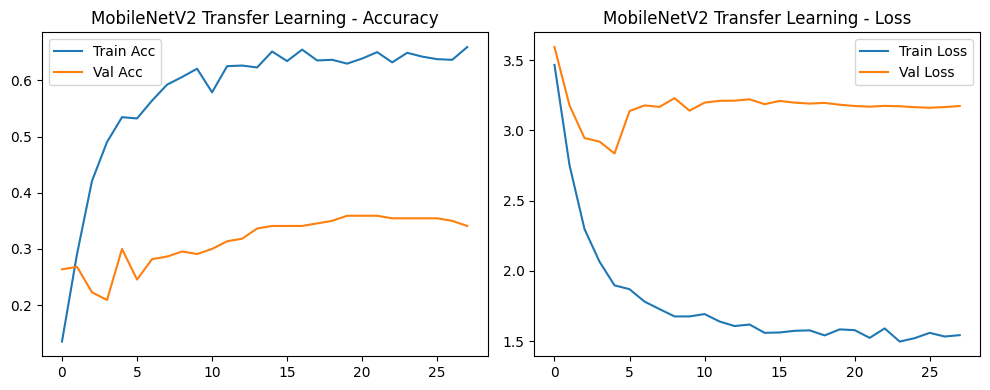

✅ Train predictions saved to train_predictions.csv


In [ ]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW


# ======================================================
# 🔧 PATH FIXER
# ======================================================
def fix_data_generators(train_df, base_path):
    """Perbaiki path & buat generator train/val"""
    print(f"📁 Base path: {base_path}")

    # Pastikan kolom label benar
    label_col = [c for c in train_df.columns if "label" in c.lower() or "class" in c.lower()][0]
    image_col = [c for c in train_df.columns if "file" in c.lower() or "image" in c.lower() or "path" in c.lower()][0]

    # Normalisasi label
    train_df[label_col] = train_df[label_col].astype(str).str.strip().str.title()

    # Buat full path
    def find_path(fname):
        clean = os.path.basename(str(fname))
        for folder in ["train", "images", "data", "dataset", ""]:
            path = os.path.join(base_path, folder, clean)
            if os.path.exists(path):
                return path
        return None

    train_df["full_path"] = train_df[image_col].apply(find_path)
    valid_df = train_df[train_df["full_path"].notna()]

    print(f"✅ Found {len(valid_df)}/{len(train_df)} valid images")

    # Data generator
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    shear_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)


    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen = train_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=label_col,
        target_size=(224, 224),
        class_mode="categorical",
        batch_size=32,
        subset="training",
        shuffle=True,
        seed=42
    )

    val_gen = val_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=label_col,
        target_size=(224, 224),
        class_mode="categorical",
        batch_size=32,
        subset="validation",
        shuffle=False,
        seed=42
    )

    print(f"🎯 Classes: {train_gen.class_indices}")
    return train_gen, val_gen


# ======================================================
# 🚀 TRANSFER LEARNING MODEL
# ======================================================
def create_transfer_model(num_classes=12, input_shape=(224,224,3)):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = True
    # Freeze semua layer kecuali top 80
    for layer in base.layers[:-80]:
        layer.trainable = False

    # Functional API + GlobalPooling + BatchNorm + Dropout
    x1 = layers.GlobalAveragePooling2D()(base.output)
    x2 = layers.GlobalMaxPooling2D()(base.output)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base.input, outputs=output)
    return model

def save_train_predictions_to_csv(train_gen, filename="train_predictions.csv"):
    """
    Simpan prediksi dari generator training (langsung dari hasil epoch) ke CSV.
    Tidak melakukan prediksi ulang.
    """
    # Ambil numeric labels dari generator
    numeric_labels = train_gen.classes  # index numerik kelas
    # Mapping index ke nama kelas
    class_indices = train_gen.class_indices
    inv_class_indices = {v:k for k,v in class_indices.items()}
    class_names = [inv_class_indices[i] for i in numeric_labels]

    # Ambil nama file
    filenames = [os.path.basename(f) for f in train_gen.filepaths]

    # Buat DataFrame
    df = pd.DataFrame({
        "filename": filenames,
        "pred_label": class_names
    })

    # Simpan CSV
    df.to_csv(filename, index=False)
    print(f"✅ Train predictions saved to {filename}")

# ======================================================
# 🧠 TRAINING FUNCTION
# ======================================================
def train_model(train_df, base_path, class_weights=None):
    print("🚀 TRAINING TRANSFER MODEL (MobileNetV2)...")
    train_gen, val_gen = fix_data_generators(train_df, base_path)

    num_classes = len(train_gen.class_indices)
    model = create_transfer_model(num_classes=num_classes)

    model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

    print("\n📐 Model Summary:")
    model.summary()

    callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',  # ⬅️ ubah dari 'val_loss' ke 'val_accuracy'
        patience=8,
        restore_best_weights=True,
        mode='max',              # ⬅️ pastikan mode 'max'
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'mobilenet_batik_best.keras',  # ⬅️ ganti ke format baru
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    print(f"\n✅ Final Validation Accuracy: {val_acc:.4f}")
    print(f"✅ Final Validation Loss: {val_loss:.4f}")

    model.save('mobilenet_batik_final.h5')
    print("💾 Model saved as mobilenet_batik_final.h5")

    plot_training_history(history, "MobileNetV2 Transfer Learning")

    return model, history, train_gen, val_gen


# ======================================================
# 📊 VISUALIZATION
# ======================================================
def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"{title} - Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title} - Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ======================================================
# 🏁 MAIN EXECUTION
# ======================================================
if 'train_df' in globals() and train_df is not None:
    base_path = r"C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025"
    model, history, train_gen, val_gen = train_model(train_df, base_path, class_weights=None)
else:
    print("❌ train_df not found! Please load your train CSV first.")

save_train_predictions_to_csv(train_gen, "train_predictions.csv")

    


In [ ]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW

# ======================================================
# 🔧 PATH FIXER
# ======================================================
def fix_data_generators(test_df, base_path):
    """Buat generator train/val (kalau ada label) atau test-only generator"""
    print(f"📁 Base path: {base_path}")
    print(f"📋 Kolom yang tersedia: {list(test_df.columns)}")

    # Cek apakah ada kolom label
    label_cols = [c for c in test_df.columns if "label" in c.lower() or "class" in c.lower()]
    image_col = [c for c in test_df.columns if "file" in c.lower() or "image" in c.lower() or "path" in c.lower()]
    image_col = image_col[0] if image_col else test_df.columns[0]

    # Bersihkan path
    def find_path(fname):
        clean = os.path.basename(str(fname))
        for folder in ["train", "images", "data", "dataset", ""]:
            path = os.path.join(base_path, folder, clean)
            if os.path.exists(path):
                return path
        return None

    test_df["full_path"] = test_df[image_col].apply(find_path)
    valid_df = test_df[test_df["full_path"].notna()]
    print(f"✅ Found {len(valid_df)}/{len(test_df)} valid images")

    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2 if label_cols else 0.0,
        rotation_range=25,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.25,
        shear_range=0.2,
        brightness_range=[0.7, 1.3],
        horizontal_flip=True,
        fill_mode='nearest'
    )

    if label_cols:
        label_col = label_cols[0]
        valid_df[label_col] = valid_df[label_col].astype(str).str.strip().str.title()

        train_gen = datagen.flow_from_dataframe(
            valid_df,
            x_col="full_path",
            y_col=label_col,
            target_size=(224, 224),
            class_mode="categorical",
            batch_size=32,
            subset="training",
            shuffle=True,
            seed=42
        )

        val_gen = datagen.flow_from_dataframe(
            valid_df,
            x_col="full_path",
            y_col=label_col,
            target_size=(224, 224),
            class_mode="categorical",
            batch_size=32,
            subset="validation",
            shuffle=False,
            seed=42
        )

        print(f"🎯 Classes: {train_gen.class_indices}")
        return train_gen, val_gen
    else:
        # Tanpa label → hanya test generator
        test_gen = datagen.flow_from_dataframe(
            valid_df,
            x_col="full_path",
            y_col=None,
            target_size=(224, 224),
            class_mode=None,
            batch_size=32,
            shuffle=False
        )
        print("🎯 Generator siap dipakai (tanpa label, mode prediksi).")
        return test_gen, None





# ======================================================
# 🚀 TRANSFER LEARNING MODEL
# ======================================================
def create_transfer_model(num_classes=12, input_shape=(224,224,3)):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = True
    for layer in base.layers[:-80]:
        layer.trainable = False

    x1 = layers.GlobalAveragePooling2D()(base.output)
    x2 = layers.GlobalMaxPooling2D()(base.output)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base.input, outputs=output)
    return model


# ======================================================
# 📈 SAVE TEST PREDICTIONS
# ======================================================
def save_test_predictions_to_csv(model, test_df, base_path, filename="test_predictions.csv"):
    """Prediksi hasil model untuk test_df dan simpan ke CSV"""
    print("🔍 Generating predictions for test data...")

    image_col = [c for c in test_df.columns if "file" in c.lower() or "image" in c.lower() or "path" in c.lower()][0]

    def find_path(fname):
        clean = os.path.basename(str(fname))
        for folder in ["test", "images", "data", "dataset", ""]:
            path = os.path.join(base_path, folder, clean)
            if os.path.exists(path):
                return path
        return None

    test_df["full_path"] = test_df[image_col].apply(find_path)
    valid_df = test_df[test_df["full_path"].notna()]

    test_datagen = ImageDataGenerator(rescale=1./255)
    predict_gen = test_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=None,
        target_size=(224, 224),
        class_mode=None,
        batch_size=32,
        shuffle=False
    )

    preds = model.predict(predict_gen, verbose=1)
    pred_labels = preds.argmax(axis=1)

    if hasattr(predict_gen, "class_indices"):
        inv_class_indices = {v: k for k, v in predict_gen.class_indices.items()}
        pred_class_names = [inv_class_indices[i] for i in pred_labels]
    else:
        pred_class_names = [str(i) for i in pred_labels]

    filenames = [os.path.basename(f) for f in predict_gen.filenames]

    df = pd.DataFrame({
        "filename": filenames,
        "pred_label": pred_class_names
    })

    df.to_csv(filename, index=False)
    print(f"✅ Test predictions saved to {filename}")


# ======================================================
# 🧠 TRAINING FUNCTION
# ======================================================
def train_model(test_df, base_path, class_weights=None):
    print("🚀 TRAINING TRANSFER MODEL (MobileNetV2)...")
    test_gen, val_gen = fix_data_generators(test_df, base_path)

    num_classes = len(test_gen.class_indices)
    model = create_transfer_model(num_classes=num_classes)

    model.compile(
        optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    print("\n📐 Model Summary:")
    model.summary()

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'mobilenet_batik_best.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]

    history = model.fit(
        test_gen,
        validation_data=val_gen,
        epochs=30,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    print(f"\n✅ Final Validation Accuracy: {val_acc:.4f}")
    print(f"✅ Final Validation Loss: {val_loss:.4f}")

    model.save('mobilenet_batik_final.h5')
    print("💾 Model saved as mobilenet_batik_final.h5")

    plot_training_history(history, "MobileNetV2 Transfer Learning")

    return model, history, test_gen, val_gen


# ======================================================
# 📊 VISUALIZATION
# ======================================================
def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"{title} - Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title} - Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ======================================================
# 🏁 MAIN EXECUTION
# ======================================================
if 'test_df' in globals() and test_df is not None:
    base_path = r"C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025"
    model, history, test_gen, val_gen = train_model(test_df, base_path, class_weights=None)

    if 'test_df' in globals() and test_df is not None:
        save_test_predictions_to_csv(model, test_df, base_path, "test_predictions.csv")
    else:
        print("⚠️ test_df not found, skipping prediction step.")
else:
    print("❌ test_df not found! Please load your test CSV first.")


🚀 TRAINING TRANSFER MODEL (MobileNetV2)...
📁 Base path: C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025
📋 Kolom yang tersedia: ['id', 'filename', 'full_path']
✅ Found 741/741 valid images
Found 741 validated image filenames.
🎯 Generator siap dipakai.


AttributeError: 'DataFrameIterator' object has no attribute 'class_indices'

In [23]:

# Create full paths (same logic as train)
def find_test_path(fname):
    clean = os.path.basename(str(fname))
    for folder in ["test", "images", "data", "dataset", ""]:
        path = os.path.join(base_path, folder, clean)
        if os.path.exists(path):
            return path
    return None

test_df["full_path"] = test_df["filename"].apply(find_test_path)
test_df = test_df[test_df["full_path"].notna()]
print(f"✅ Found {len(test_df)} valid test images")
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col="full_path",
    y_col=None,  # no labels
    target_size=(224,224),
    class_mode=None,
    batch_size=32,
    shuffle=False
)
pred_probs = model.predict(test_gen, verbose=1)
pred_labels = pred_probs.argmax(axis=1)  # numeric class indices

# Map numeric indices back to class names
class_indices = train_gen.class_indices  # {'Aseman':0, ...}
inv_class_indices = {v:k for k,v in class_indices.items()}
pred_class_names = [inv_class_indices[i] for i in pred_labels]

submission = pd.DataFrame({
    "id": test_df["id"],
    "label": pred_class_names
})

submission.to_csv("sample_submission.csv", index=False)
print("✅ Predictions saved to sample_submission.csv")





✅ Found 741 valid test images
Found 741 validated image filenames.


c:\Users\Elsie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step
✅ Predictions saved to sample_submission.csv
